In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import utils
from utils.get_nn_models import *
from utils.sbiutils import *
from utils.torchutils import *
from inference.base import *
import torch
import pickle
import seaborn as sns
import io
from utils.corruption import *
from simulators.oup import oup

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

%load_ext autoreload
%autoreload 2

cpu


In [2]:
def load_models(root_name: str, device: torch.device):
    sum_net = torch.load("{root_name}/sum_net.pkl".format(root_name=root_name), map_location=device)

    density_estimator = torch.load("{root_name}/density_estimator.pkl".format(root_name=root_name), map_location=device)

    with open("{root_name}/posterior.pkl".format(root_name=root_name), "rb") as handle:
        posterior = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
#     with open("{root_name}/inference.pkl".format(root_name=root_name), "rb") as handle:
#         inference = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
    return sum_net, density_estimator, posterior

In [10]:
def read_rnpe(model="oup", misspecified=1, degree=0, seed=1, theta=[0.5,1.0]):
    file = f"seed={seed}_degree={degree}_var={misspecified}_theta={theta}_{model}"

    results_dir = f"objects/rnpe/{model}"
    fn = f"{results_dir}/{file}.pickle"

    with open(fn, "rb") as f:
        results = pickle.load(f)

    return np.array(results['posterior_samples']['RNPE'])

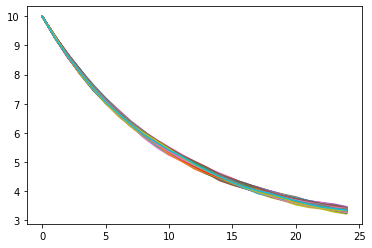

In [90]:
n = 25
theta = torch.tensor([0.5, 1])
simulator = oup(n=n, var=0.1, N=100)
Y = simulator(theta)
for i in range(100):
    plt.plot(range(n), Y[i])

In [37]:
degree=0.1
N=100
n_corrupted = int(N * degree)
n_normal = int(N - n_corrupted)
simulator = oup(var=1.0, N=N)
theta_gt = torch.tensor([0.5, 1])
theta_cont = torch.tensor([-0.5, 1])
obs = simulator(theta_gt).to(device)
obs_2 = simulator(theta_cont).to(device)
obs_cont = torch.cat([obs[:n_normal], obs_2[:n_corrupted]], dim=0).reshape(-1, N, 25)

x = torch.tensor(np.load("data/oup_x_1000.npy")).to(device)
theta = torch.tensor(np.load("data/oup_theta_1000.npy")).to(device)
print("x shape", x.shape)
print("theta shape", theta.shape)

x shape torch.Size([1000, 2500])
theta shape torch.Size([1000, 2])


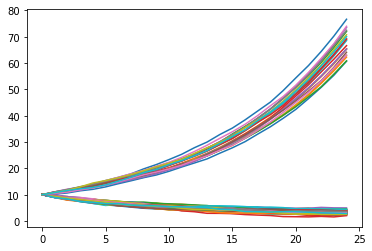

In [6]:
for i in range(100):
    plt.plot(range(25), obs_cont[0][i])

In [147]:
# some good runs, can't work now as I changed the network structure
# root_name = "objects/oup/var=1_mmd_beta=2.0_theta=[0.5, 1.0]_num=1000/7"
# root_name = "objects/oup/var=1_mmd_beta=2.0_theta=[0.5, 1.0]_num=1000/2"
# root_name = "objects/oup/var=1_mmd_beta=2.0_theta=[0.5, 1.0]_num=500/2"
# root_name = "objects/oup/var=0.1_mmd_beta=2.0_theta=[0.5, 1.0]_num=500/8"
# root_name = "objects/oup/var=0.1_mmd_beta=3.0_theta=[0.5, 1.0]_num=500/4"
sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)

# root_name = "objects/oup/var=1_none_beta=2.0_theta=[0.5, 1.0]_num=1000/1"
# root_name = "objects/oup/var=1_none_beta=2.0_theta=[0.5, 1.0]_num=1000/9"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

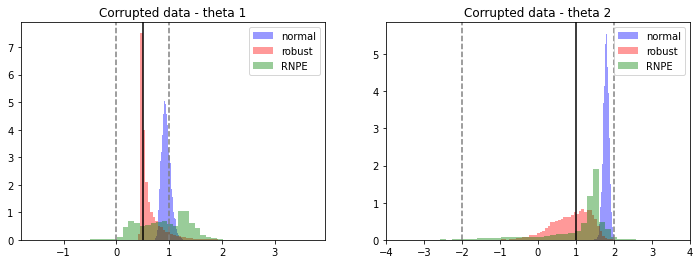

In [59]:
# num=2000 0.2:  1 5 7 8 9 12good 23good
# num=2000 0.1 2 3good 4perfect 22good
# num=1000 0.2: 2conf 8notconf 9 15 22 24?
# num=1000 0.1: 1 9 13 14 15good 21
root_name = f"objects/oup_new/degree={degree}_var=1.0_mmd_beta=2.0_theta=[0.5, 1.0]_num=1000_N=100/9"
sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)
# 1000 var=1  1 2 10 11 12perfect 16good 21
# 2000 var=1 11 22good 24 28good
root_name = "objects/oup_new/var=1.0_none_num=1000_N=100/6"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)

post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, N, 25))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, N, 25))
post_samples_rnpe_cont = read_rnpe(model="oup", degree=degree, seed=12, theta='[0.5,1.0]')

np.save(f"post_samples_normal_degree={degree}.npy", post_samples_normal_cont.detach().numpy())
np.save(f"post_samples_robust_degree={degree}.npy", post_samples_robust_cont.detach().numpy())
np.save(f"post_samples_rnpe_degree={degree}.npy", post_samples_rnpe_cont)


plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
plt.axvline(x=0,ls="--",c="grey")
plt.axvline(x=1,ls="--",c="grey")
sns.distplot(post_samples_normal_cont[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_cont[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
# plt.xlim(-1, 2)
plt.title("Corrupted data - theta 1")

plt.subplot(1, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
plt.axvline(x=-2,ls="--",c="grey")
plt.axvline(x=2,ls="--",c="grey")
sns.distplot(post_samples_normal_cont[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_cont[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(-4, 4)
plt.title("Corrupted data - theta 2")
plt.show()


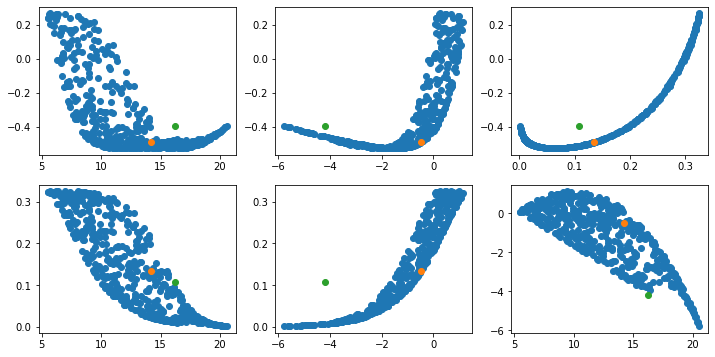

In [485]:
sum_net_normal_0 = copy.deepcopy(sum_net_normal)

obs_summary = sum_net_normal_0(obs.unsqueeze(0))[1].detach().numpy()
obs_cont_summary = sum_net_normal_0(obs_cont.unsqueeze(0))[1].detach().numpy()

x_summary = sum_net_normal_0(x[:500])[1].detach().numpy()

plt.figure(figsize=(12,6))
plt.subplot(2, 3, 1)
plt.scatter(x_summary[:, 0], x_summary[:, 3])
plt.scatter(obs_summary[0, 0], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 3])

plt.subplot(2, 3, 2)
plt.scatter(x_summary[:, 1], x_summary[:, 3])
plt.scatter(obs_summary[0, 1], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 1], obs_cont_summary[0, 3])

plt.subplot(2, 3, 3)
plt.scatter(x_summary[:, 2], x_summary[:, 3])
plt.scatter(obs_summary[0, 2], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 2], obs_cont_summary[0, 3])

plt.subplot(2, 3, 4)
plt.scatter(x_summary[:, 0], x_summary[:, 2])
plt.scatter(obs_summary[0, 0], obs_summary[0, 2])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 2])

plt.subplot(2, 3, 5)
plt.scatter(x_summary[:, 1], x_summary[:, 2])
plt.scatter(obs_summary[0, 1], obs_summary[0, 2])
plt.scatter(obs_cont_summary[0, 1], obs_cont_summary[0, 2])

plt.subplot(2, 3, 6)
plt.scatter(x_summary[:, 0], x_summary[:, 1])
plt.scatter(obs_summary[0, 0], obs_summary[0, 1])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 1])
plt.show()